## Problem 1

Consider the electric dipole illustrated below. Calculate the potential generated by the dipole.

In [ ]:
import numpy as np
from scipy.sparse import diags
from scipy.linalg import eigh
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm

plt.rcParams.update({'font.size': 16})

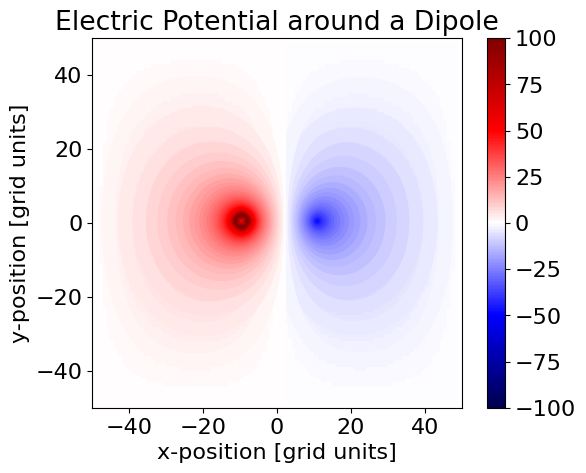

In [ ]:
# Update plot font size
plt.rcParams.update({'font.size': 16})

# Grid parameters
grid_dim = 100  # 100x100 grid
center_pos = grid_dim // 2  # Position of the charges (center)
spacing = 10  # Separation in grid points representing the charge distance
positive_potential = 100  # Potential at the positive charge
negative_potential = -100  # Potential at the negative charge
convergence_threshold = 1e-5  # Convergence criterion

# Initialize grid for potential
potential_field = np.zeros((grid_dim, grid_dim))

# Assign potentials to the charge locations
potential_field[center_pos, center_pos - spacing] = positive_potential  # Positive charge
potential_field[center_pos, center_pos + spacing] = negative_potential  # Negative charge

# Function to iteratively update the potential using Gauss-Seidel method
def compute_potential(grid, max_iterations=10000):
    for _ in range(max_iterations):
        previous_grid = grid.copy()

        # Loop over interior grid points to update potential
        for x in range(1, grid_dim-1):
            for y in range(1, grid_dim-1):
                if not ((x == center_pos and y == center_pos + spacing)
                        or (x == center_pos and y == center_pos - spacing)):
                    grid[x, y] = (grid[x+1, y] + grid[x-1, y] + grid[x, y+1] + grid[x, y-1]) / 4

        # Check for convergence
        max_diff = np.max(np.abs(grid - previous_grid))
        if max_diff < convergence_threshold:
            break
    return grid

# Calculate the converged potential
final_potential = compute_potential(potential_field)

# Define normalization for color map (with 0 as center)
normalization = TwoSlopeNorm(vmin=negative_potential, vcenter=0, vmax=positive_potential)

# Plot the final potential field
plt.imshow(final_potential, cmap='seismic', norm=normalization, interpolation='nearest',
           extent=[-grid_dim/2, grid_dim/2, -grid_dim/2, grid_dim/2])
plt.colorbar()

# Add contour lines for clarity
contours = plt.contour(final_potential, levels=100, cmap='seismic', norm=normalization, linewidths=10,
                       extent=[-grid_dim/2, grid_dim/2, -grid_dim/2, grid_dim/2])

# Set plot titles and labels
plt.title('Electric Potential around a Dipole')
plt.xlabel('x-position [grid units]')
plt.ylabel('y-position [grid units]')
plt.show()


## Problem 2

It’s the day before Thanksgiving and you misplaced the recipe for baking the turkey. You decide to use the heat equation to simulate the cooking of your frozen turkey. Assume a spherical turkey at T = 0C. What is the cooking time? The cooking time is the time needed for the internal temperature of the turkey to reach 74C. Assume K=C=𝜌=1 and an oven temperature of 180C.

The center of the turkey reaches 74°C after 0.30595 seconds.


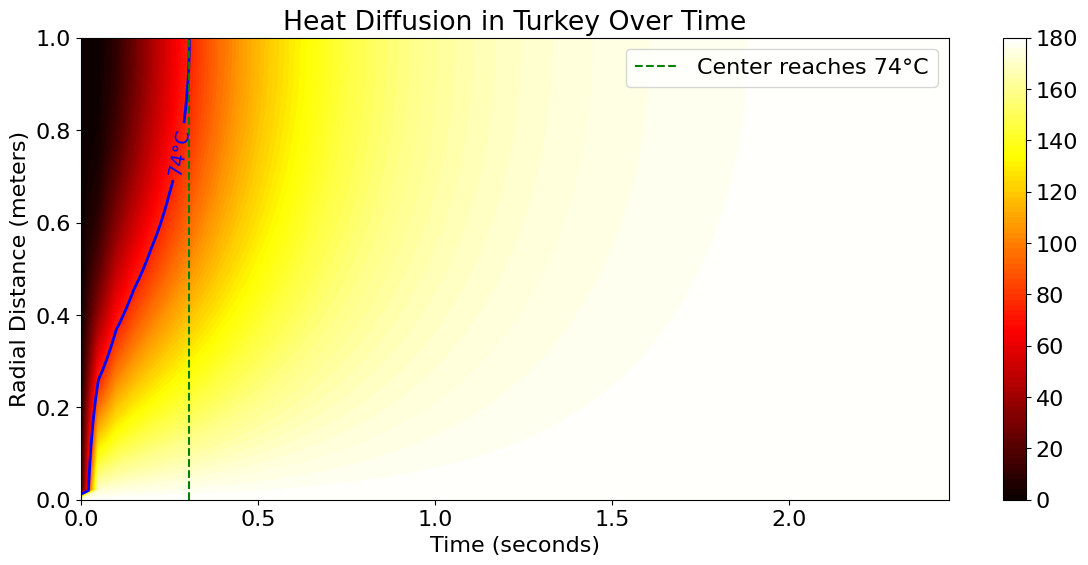

In [ ]:
# Parameters
thermal_conductivity = specific_heat = density = 1  # Thermal properties
oven_temperature = 180  # Oven temperature in Celsius
target_internal_temp = 74  # Target internal temperature in Celsius

# Initial conditions
initial_temp = 0  # Initial turkey temperature
turkey_radius = 1  # Approximate radius of turkey (in meters)
spatial_step = 0.02  # Radial spatial resolution (in meters)
time_step = 0.00005  # Time step size (in seconds)

# Grid dimensions
num_r_points = int(turkey_radius / spatial_step) + 1
num_t_points = 50000

# Temperature grid initialization
temp_grid = np.zeros((num_r_points, num_t_points))
temp_grid[:, 0] = initial_temp  # Initial temperature at all points
temp_grid[0, :] = oven_temperature  # Surface at oven temperature

# Simulate heat diffusion using explicit finite difference method
for time_idx in range(num_t_points - 1):
    for rad_idx in range(1, num_r_points - 1):
        temp_grid[rad_idx, time_idx + 1] = (temp_grid[rad_idx, time_idx] +
                                            (thermal_conductivity * time_step / (specific_heat * density * spatial_step ** 2)) *
                                            (temp_grid[rad_idx + 1, time_idx] - 2 * temp_grid[rad_idx, time_idx] + temp_grid[rad_idx - 1, time_idx]))

    # Boundary conditions
    temp_grid[0, time_idx + 1] = oven_temperature  # Surface of turkey
    temp_grid[-1, time_idx + 1] = temp_grid[-2, time_idx + 1]  # Insulating boundary at the center

# Find time when center reaches target temperature
center_temp_reached = np.where(temp_grid[-1, :] >= target_internal_temp)[0]
if center_temp_reached.size > 0:
    time_to_reach_target = center_temp_reached[0] * time_step
    print(f"The center of the turkey reaches {target_internal_temp}°C after {time_to_reach_target} seconds.")
else:
    print("The center of the turkey does not reach the target temperature within the simulation time.")

# Select points for plotting
plot_interval = 1000
temp_for_plot = temp_grid[:, ::plot_interval]
time_values = np.arange(0, num_t_points * time_step, plot_interval * time_step)
radius_values = np.linspace(0, turkey_radius, num_r_points)

# Create meshgrid for contour plot
R_grid, T_grid = np.meshgrid(radius_values, time_values)

# Create the contour plot with contour levels
plt.figure(figsize=(14, 6))
contour_plot = plt.contourf(T_grid, R_grid, temp_for_plot.T, cmap='hot', levels=100)
plt.colorbar(contour_plot)
plt.title('Heat Diffusion in Turkey Over Time')
plt.xlabel('Time (seconds)')
plt.ylabel('Radial Distance (meters)')

# Add contour line for the target temperature
target_temp_contour = plt.contour(T_grid, R_grid, temp_for_plot.T, levels=[target_internal_temp], colors='blue', linewidths=2)
plt.clabel(target_temp_contour, inline=True, fontsize=14, fmt=f'{target_internal_temp}°C', manual=[(2, 0.5)])

# Mark when the center reaches the target temperature
if center_temp_reached.size > 0:
    plt.axvline(x=time_to_reach_target, color='green', linestyle='--', label=f'Center reaches {target_internal_temp}°C')
    plt.legend()

plt.show()


## Problem 3

Consider a square well with a pole. Calculate the eigenfunctions and eigenvalues of the discretized 2D Schrodinger equation using tools from linear algebra.

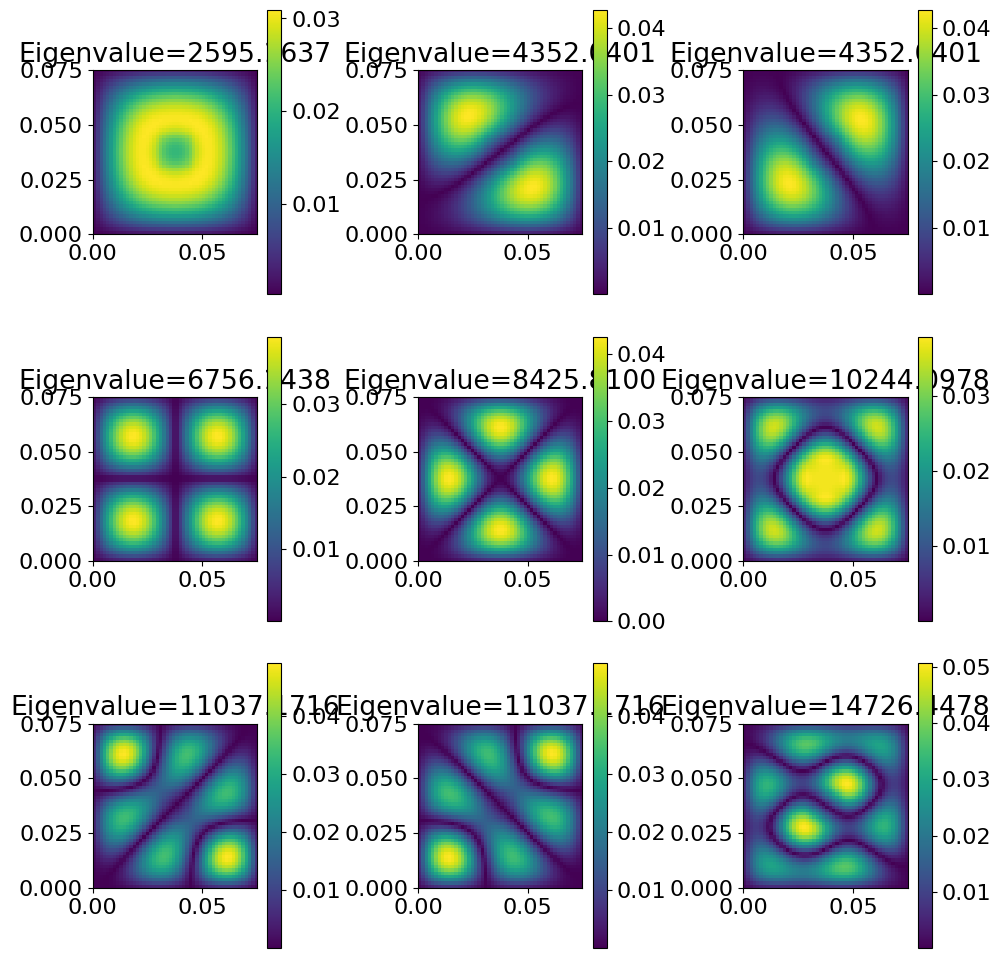

In [9]:
from scipy.sparse import diags
from scipy.linalg import eigh

# 1. Initialize grid and potential parameters
grid_size = 50  # Grid size (number of points)
spacing = 0.0015  # Space between each point on the grid (in meters)

# Define potential values
well_potential = 0  # Potential in the well region
boundary_potential = 100  # Potential at the boundary (if the well is not infinite)
pole_potential = 10000  # Potential at the pole
pole_dimension = 10  # Size of the pole region

# Initialize potential matrix with well potential
potential_field = well_potential * np.ones((grid_size, grid_size))

# Apply boundary potential at the grid boundaries
potential_field[0, :] = boundary_potential
potential_field[-1, :] = boundary_potential
potential_field[:, 0] = boundary_potential
potential_field[:, -1] = boundary_potential

# Add the pole to the center of the potential field
center_index = grid_size // 2
potential_field[center_index - pole_dimension // 2:center_index + pole_dimension // 2,
                center_index - pole_dimension // 2:center_index + pole_dimension // 2] = pole_potential

# 2. Construct Hamiltonian
# Define the Laplacian (kinetic energy term)
laplace_operator = diags([1, -2, 1], [-1, 0, 1], shape=(grid_size, grid_size))
laplace_operator = laplace_operator / (spacing ** 2)  # Finite difference approximation

# Use Kronecker product to create the 2D Laplacian operator
kinetic_energy = -0.5 * (np.kron(laplace_operator.toarray(), np.eye(grid_size)) +
                         np.kron(np.eye(grid_size), laplace_operator.toarray()))

# Flatten the potential field for compatibility with the Hamiltonian matrix
potential_flat = potential_field.flatten()

# Construct the full Hamiltonian matrix
hamiltonian = kinetic_energy + np.diag(potential_flat)

# 3. Solve for eigenvalues and eigenvectors
eigenvals, eigenvecs = eigh(hamiltonian)

# 4. Visualization of the first few eigenstates
num_states = 9  # Number of eigenstates to visualize

# Create subplots for displaying wavefunctions
fig, axes = plt.subplots(3, 3, figsize=(10, 10))

# Plot the first 'num_states' eigenstates' wavefunctions
for state_idx in range(num_states):
    ax = axes[state_idx // 3, state_idx % 3]
    wavefunction = np.abs(eigenvecs[:, state_idx].reshape((grid_size, grid_size)))
    img = ax.imshow(wavefunction, extent=(0, grid_size * spacing, 0, grid_size * spacing), origin='lower')
    ax.set_title(f'Eigenvalue={eigenvals[state_idx]:.4f}')
    plt.colorbar(img, ax=ax)

plt.tight_layout()
plt.show()
